# Examples

We are going to use two examples to illustrate how to use Kulprit for variable selection. 

* Body Fat: We will use the bodyfat data set {cite}`Penrose_1985`. The aim of the analysis is to predict an expensive and cumbersome water immersion measurement of body fat percentage (observed variable named `siri`) from a set of thirteen easier to measure characteristics, including `age`, `height`, `weight`, and circumferences of various body parts.

* Bikes: This dataset contains the number of bike rentals per hour (`count`) in a bike-sharing system, along with several features that can be used to predict the number of rentals, including `temperature`, `windspeed`, `hour`, among others. We will use all the variables in the dataset.

In [1]:
from arviz_plots import style
import bambi as bmb
import kulprit as kpt
import numpy as np
import pandas as pd

style.use("arviz-variat")
SEED = 9352
np.random.seed(SEED)

## Body Fat

The first thing we need to do is to load the data and define a model using Bambi. We are going to use a linear regression with Normal response. We need to set `idata_kwargs={'log_likelihood': True}` as we will later need to compute the [ELPD](https://arviz-devs.github.io/Exploratory-Analysis-of-Bayesian-Models/Chapters/Model_comparison.html#waic) of the reference models and submodels.

In [2]:
body = pd.read_csv("body_fat.csv")
model = bmb.Model("siri ~" +  " + ".join([c for c in body.columns if c!="siri"]), data=body)
idata = model.fit(idata_kwargs={'log_likelihood': True}, random_seed=SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, age, weight, height, neck, chest, abdomen, hip, thigh, knee, ankle, biceps, forearm, wrist]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


### Performing the projection

To use Kulprit we first instantiate the `ProjectionPredictive` class and then call the `project` method, which is the one doing all the hard work.

In [3]:
ppi = kpt.ProjectionPredictive(model, idata)
ppi.project()

### Inspecting the results

Once this is finished we can print the `ppi` object. It will give us a list of the submodels in order of lowest ELPD to highest ELPD. The first model is always the intercept-only model, represented as an empty list. 

In [4]:
ppi

  0 []
  1 ['abdomen']
  2 ['abdomen', 'weight']
  3 ['abdomen', 'weight', 'wrist']
  4 ['abdomen', 'weight', 'wrist', 'age']
  5 ['abdomen', 'weight', 'wrist', 'age', 'height']
  6 ['abdomen', 'weight', 'wrist', 'age', 'height', 'thigh']
  7 ['abdomen', 'weight', 'wrist', 'age', 'height', 'thigh', 'forearm']
  8 ['abdomen', 'weight', 'wrist', 'age', 'height', 'thigh', 'forearm', 'neck']
  9 ['abdomen', 'weight', 'wrist', 'age', 'height', 'thigh', 'forearm', 'neck', 'biceps']
 10 ['abdomen', 'weight', 'wrist', 'age', 'height', 'thigh', 'forearm', 'neck', 'biceps', 'ankle']
 11 ['abdomen', 'weight', 'wrist', 'age', 'height', 'thigh', 'forearm', 'neck', 'biceps', 'ankle', 'knee']
 12 ['abdomen', 'weight', 'wrist', 'age', 'height', 'thigh', 'forearm', 'neck', 'biceps', 'ankle', 'knee', 'chest']
 13 ['abdomen', 'weight', 'wrist', 'age', 'height', 'thigh', 'forearm', 'neck', 'biceps', 'ankle', 'knee', 'chest', 'hip']

The [ELPD](https://arviz-devs.github.io/EABM/Chapters/Model_comparison.html#elpd) is a measure of how well the model predicts the data, the higher the ELPD, the better the model. The ELPD is computed using the [Pareto smoothed importance sampling leave-one-out cross-validation](https://arxiv.org/abs/1507.04544) (PSIS-LOO-CV) method, which is an efficient way to approximate leave-one-out cross-validation {cite}`Vehtari_2017, Vehtari_2024`.

Using the method `compare` we can get a DataFrame ELPD of the reference model and all the submodels. The DataFrame also includes the standard error of the ELPD. The reference model is always on the first row, followed by the submodels in order of increasing ELPD.

In the following code block we are asking for all the submodels with minimum size of 1, that is, we are excluding the intercept-only model. We are also showing the transposed DataFrame with values rounded to 2 decimal places for better readability.

In [5]:
cmp_df = ppi.compare(min_model_size=1, round_to=2)
cmp_df.T

,reference,hip,chest,knee,ankle,biceps,neck,forearm,thigh,height,age,wrist,weight,abdomen
elpd,-726.84,-722.71,-723.08,-723.40,-722.99,-722.32,-722.33,-723.24,-723.56,-724.42,-725.43,-725.78,-730.09,-747.75
se,9.39,8.69,8.57,8.71,8.67,8.66,8.72,8.70,8.59,8.56,8.53,8.47,8.59,8.86


Reading a table/DataFrame can be hard, So we usually recommend instead to focus on visually checking the results using the `plot_compare` function. This function represents the reference model's ELPD as a horizontal line, with a band representing the uncertainty of the estimate. The submodels are represented as points, with a vertical line representing the uncertainty of the estimate.

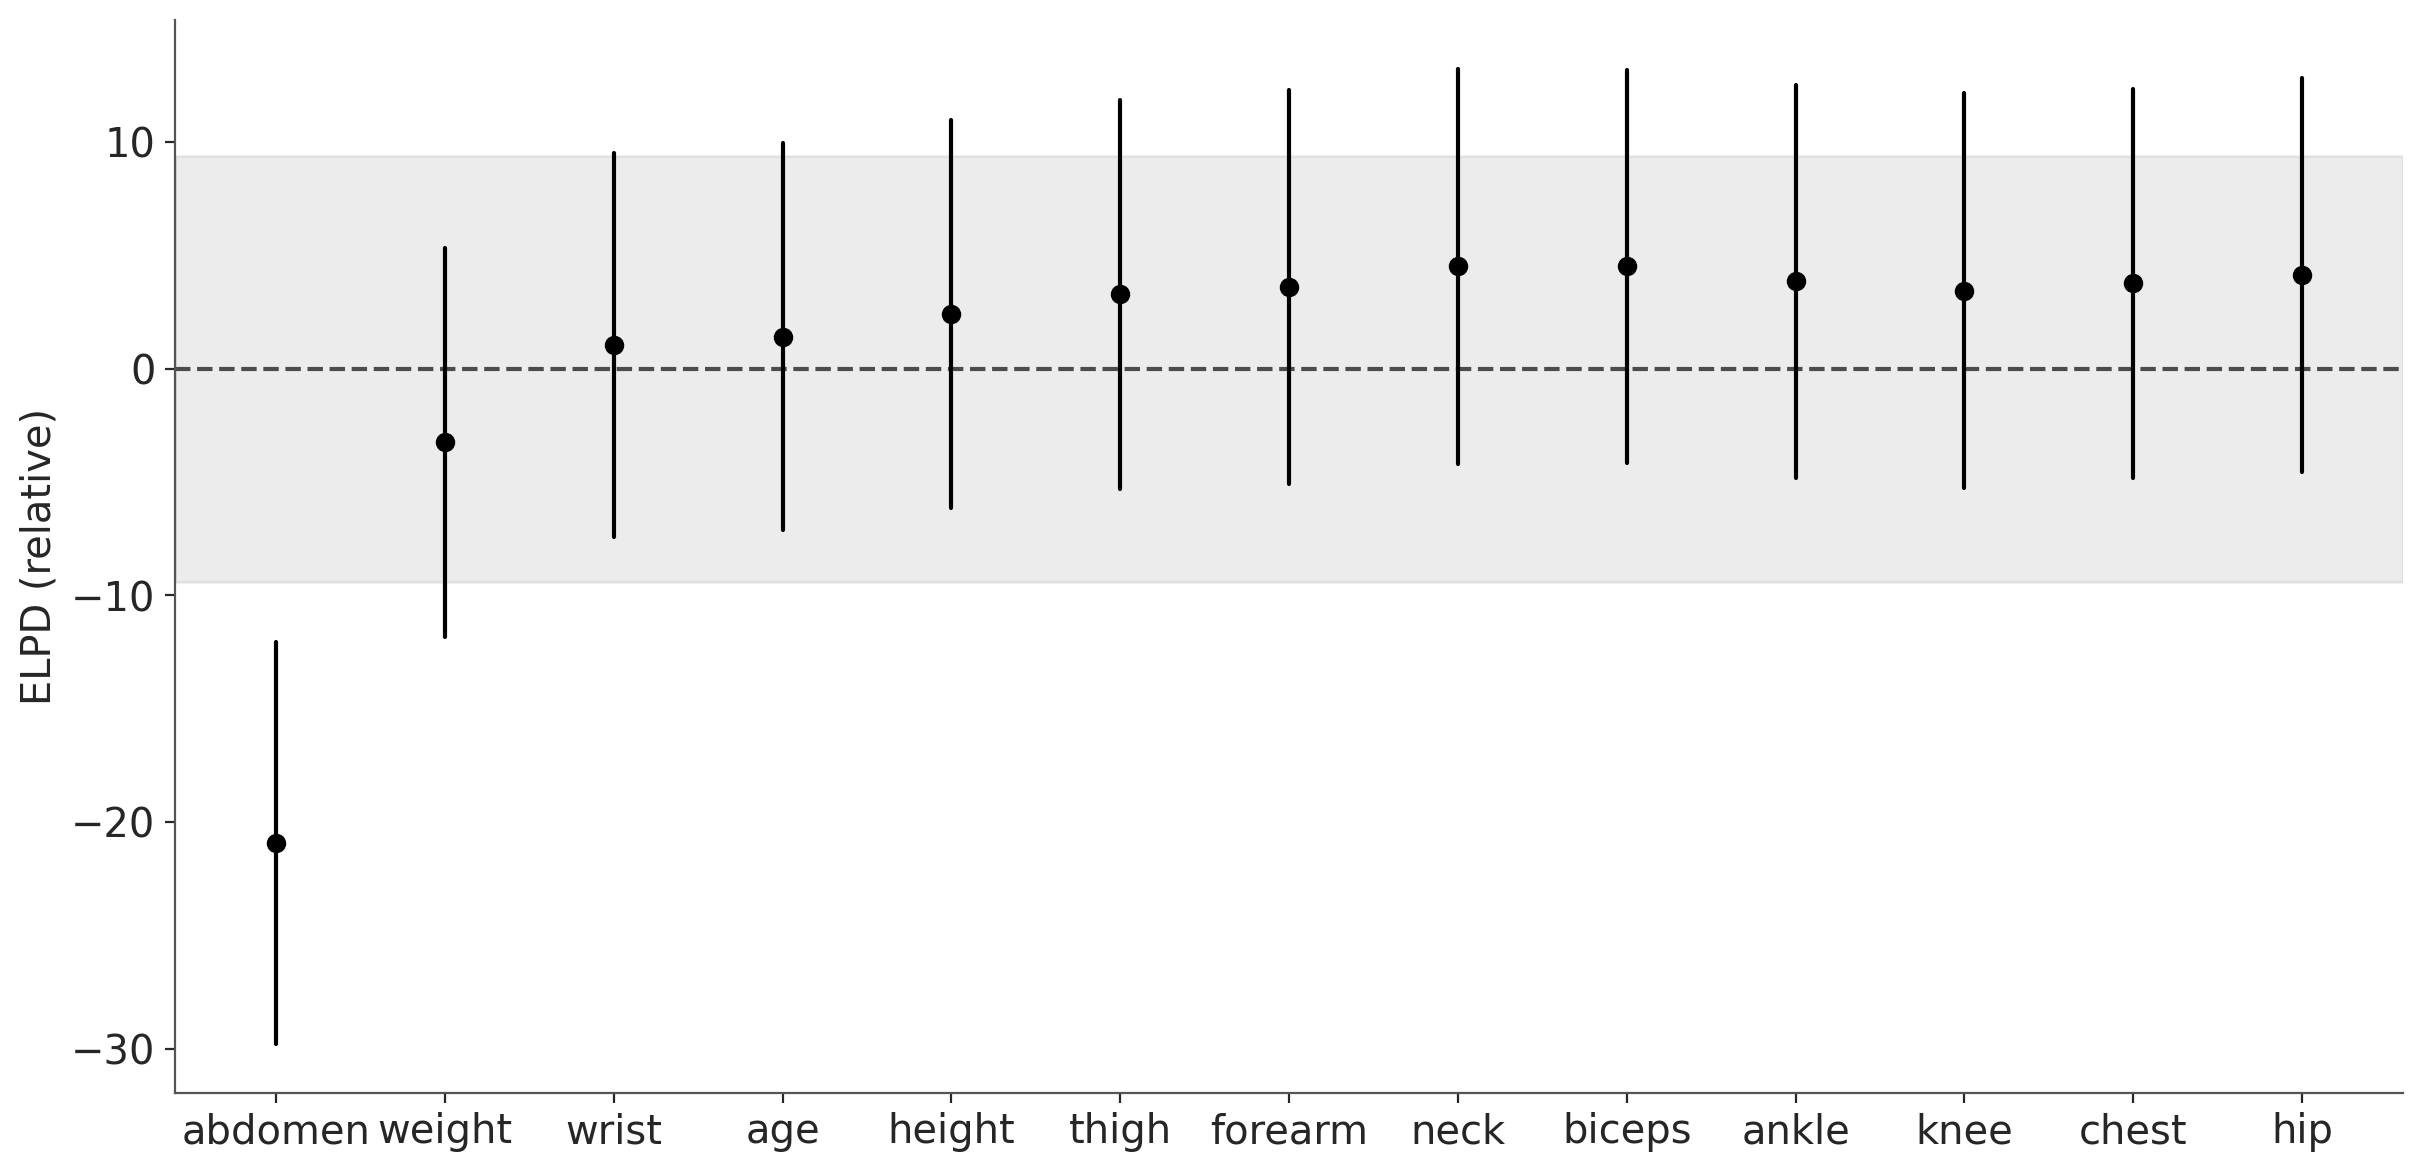

In [6]:
kpt.plot_compare(cmp_df);

From this plot we can see that the most relevant variable is `abdomen`, in the sense that if we were forced to pick a single variable, picking `abdomen` would be the one that would make the predictions most similar to the reference model. But the difference of ELPD between the submodel `abdomen` and the reference model is large, so we may want to include more variables. If we include two variables `abdomen` and `weight`, or maybe tree `abdomen`, `weight` and `wrist` we should get a model that is statistically indistinguishable from the reference model (under the ELPD metric). 

The error bars give us an idea of the uncertainty of the ELPD estimate. This is telling us that if we repeat the experiment many times (or computation using a different seed or bootstrap the data), we should expect to get `abdomen` as the most relevant variable almost 100% of the time. For the second position, `weight` and `wrist` are the most likely contenders, though other variables could occasionally take that spot. Similarly, from the previous figure it would not be meaningful to claim that `forearm` is more relevant than `hip`.

### Automated selection of submodels

`plot_compare` provides very useful information in a visual way. However, sometimes we may want a more automated way to select the submodels. This can be done by calling the `select` method. If we use the `select` method for our example, we see that the selected submodel is the one with `abdomen` and `weight` (plus the intercept, that is always included).

In [7]:
selected_submodel = ppi.select()
selected_submodel

['Intercept', 'abdomen', 'weight']

When using the `select` method we have two options: `mean` (the default one) and `se`. `mean` selects the smallest submodel with an ELPD that is within 4 units of the reference model. The "se" methods selects the smallest submodel with an ELPD that is within one standard error of the reference model. Both criteria behave similarly. Usually, the `mean` criterion results in more stable selection, and selects larger and better-performing submodels {cite}`Mclatchie_2024`.


As usual statistical methods should help us make decisions, but they should not make decisions for us. When deciding which variables to include in the model we may prefer an order that is slightly different from the one provided by Kulprit, the decision could be based on extra information that is not included in the model. For example, after discussion with domain experts or coworkers, we might determine that weighing patients is too cumbersome and decide to include only `abdomen` and `wrist` measurements.

### Exploring the projected posterior

Usually for the purpose of variable selection we do not care about the projections themselves, as they are just an intermediate step to perform variable selection. Nevertheless, it's possible to use and explore the projected posterior. The `plot_forest` function allow us to plot the posterior marginals of the submodels (and optionally the reference model too). 

In the followin figure we can see that the posterior densities of the reference model and the largest submodel (i.e. the reference model projected onto itself) are very similar.

/home/osvaldo/anaconda3/envs/kulprit/lib/python3.12/site-packages/arviz_base/utils.py:126: UserWarning: Items starting with ~: ['mu'] have not been found and will be ignored
  warnings.warn(


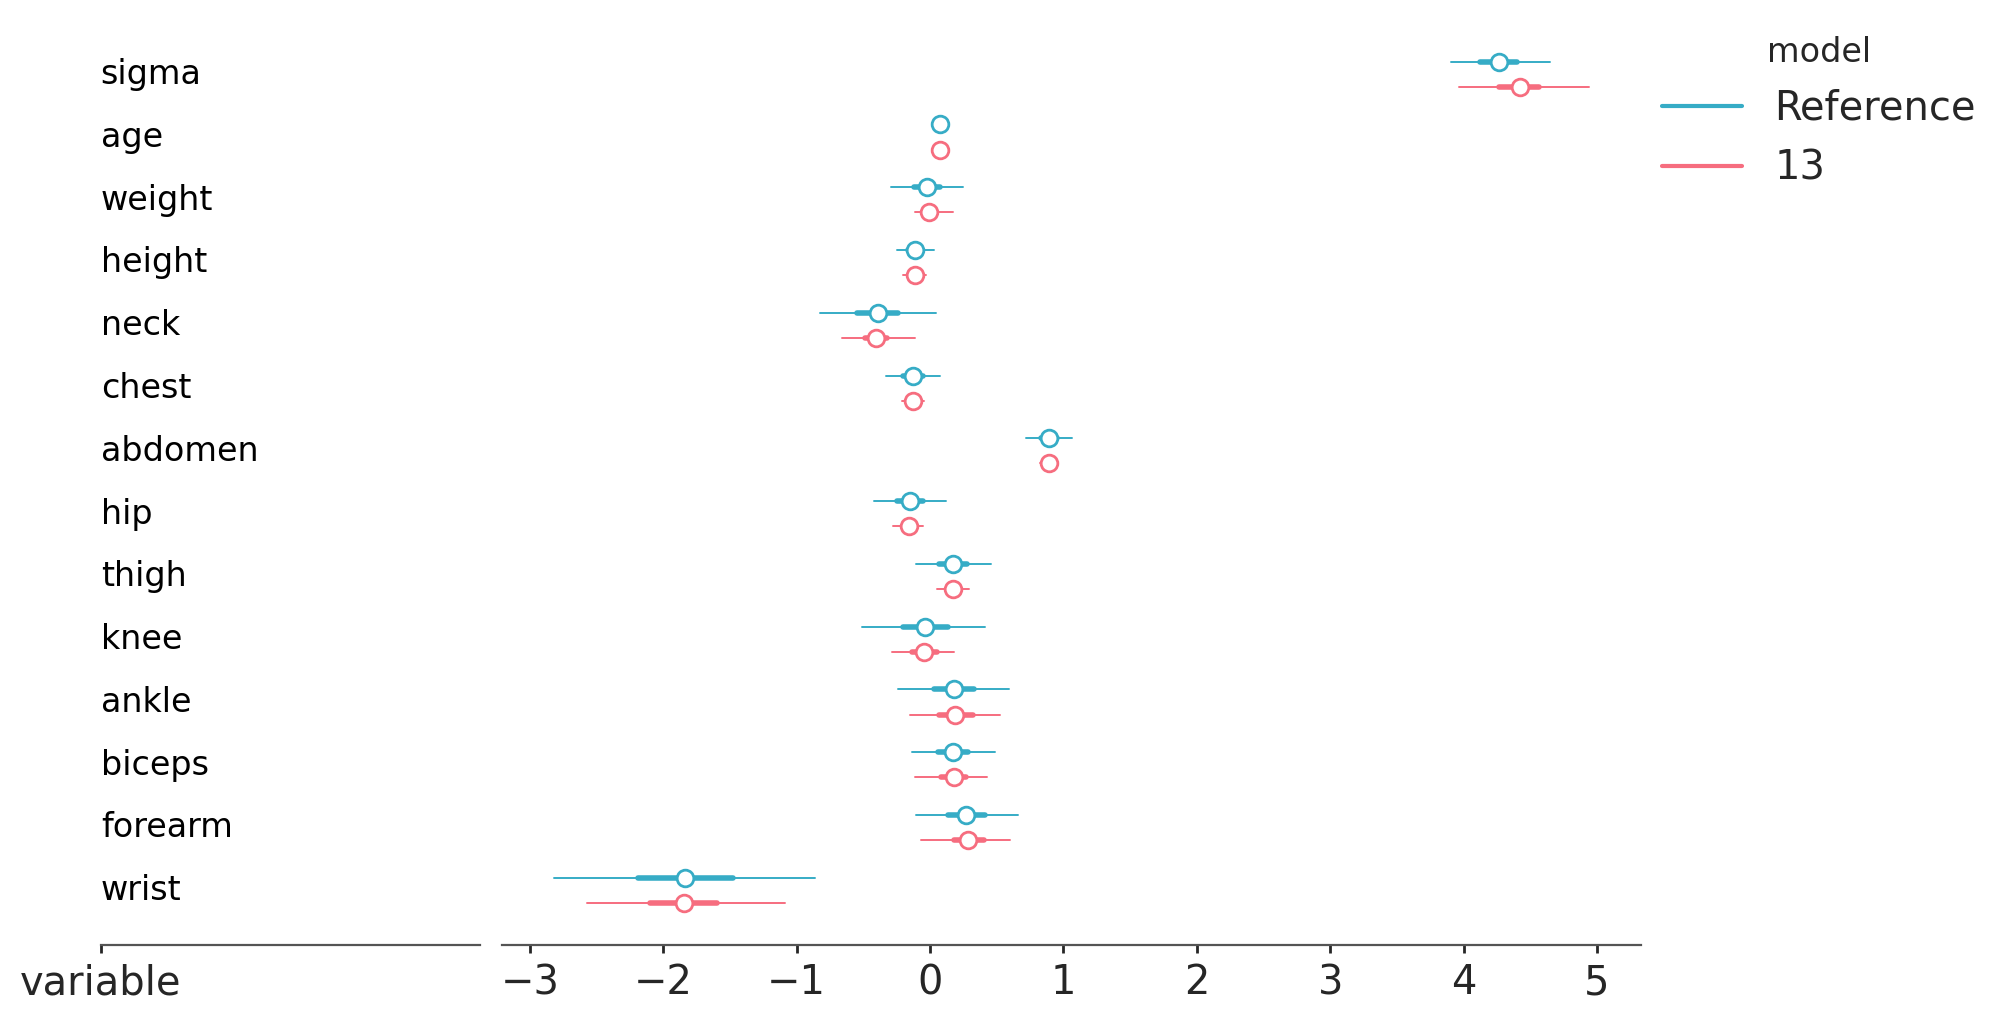

In [8]:
kpt.plot_forest(ppi, var_names=["~Intercept", "~mu"],
                   submodels=[13],
                   include_reference=True,
                   figure_kwargs={"figsize": (10, 5)},
                  );

Below we can see the projection for the submodel of size 2, `abdomen + weight`. This time using the `plot_dist` function.

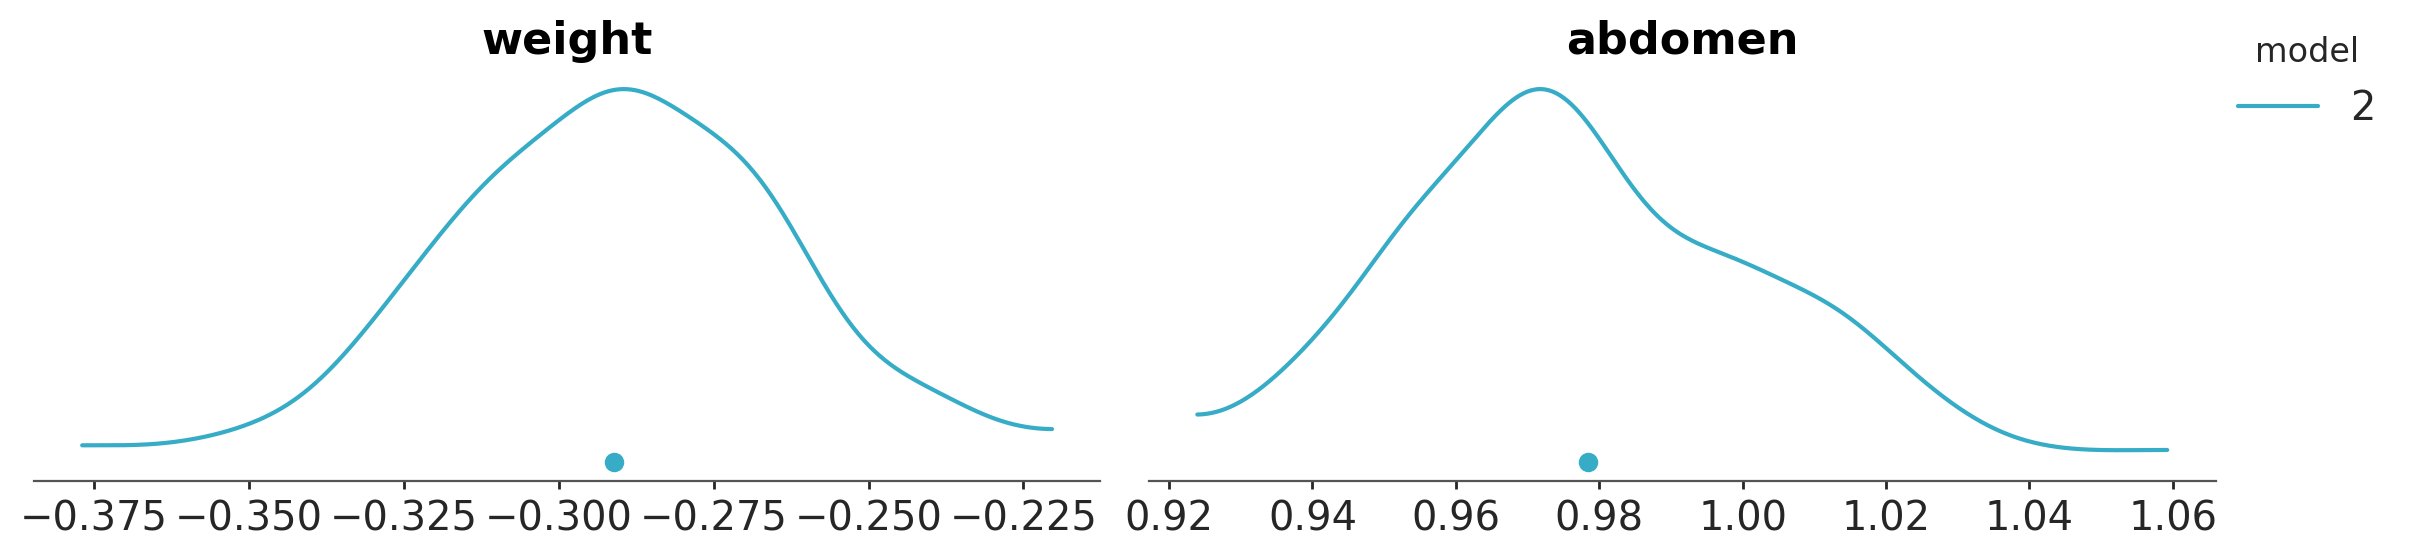

In [9]:
kpt.plot_dist(ppi, var_names=selected_submodel.term_names,
              submodels=[selected_submodel.size],
              );

The plotting functions in Kulprit are thin wrappers around [ArviZ]([ArviZ documentation](https://arviz-plots.readthedocs.io/en/latest/)'s plotting function (with the same names), and hence can further customized using the same arguments as in ArviZ. Kulprit may perform some preproccessing or change some defaults to better suit the purpose of variable selection.

## Bikes

In [10]:
bikes = pd.read_csv("bikes.csv")

One thing to note is that a linear model may have difficulties to handle the variable `hour` as it will miss the non-linearities in the data. For instance, we expect rentals to go up in the morning and in the evening, and to go down in the middle of the day and at night. To better handle this variable we could transform the variable `hour` into a set of dummy variables like 
 

```python
bikes = pd.read_csv("bikes.csv")
bikes["hour_sin"] = np.sin(bikes.hour * np.pi / 12)
bikes["hour_cos"] = np.cos(bikes.hour * np.pi / 12)
bikes.drop(columns="hour", inplace=True)
``` 

or we could use a more flexible model like splines (that is also a kind of data transformation). Let's try the latter.

In [11]:
knots = range(1, 22, 5)
priors = {
    "alpha": bmb.Prior("Exponential", lam=1)
}

model = bmb.Model("count ~ bs(hour, knots=knots, intercept=True) + " + " + ".join(bikes.columns.drop(["count", "hour"])),
                  bikes,
                  family="negativebinomial",
                  priors=priors)

model.set_alias({"bs(hour, knots=knots, intercept=True)": "bs_hour"})

### Performing the projection

This time we are going to pass Kulprit the Bambi model without fitting it. Usually it's a good idea to fit the reference model using `fit` method from bambi and then check that MCMC sampling diagnostics are ok, and the model fits well the data. It makes little sense to perform variable selection using a model that we don't trust.

In [12]:
ppi = kpt.ProjectionPredictive(model)
ppi.project()

/home/osvaldo/proyectos/00_BM/bambinos/kulprit/kulprit/projector.py:306: UserWarning: No InferenceData object provided. Building posterior from model.
  warnings.warn("No InferenceData object provided. Building posterior from model.")
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, bs_hour, season, month, holiday, weekday, workingday, weather, temperature, humidity, windspeed]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.


### Inspecting the results

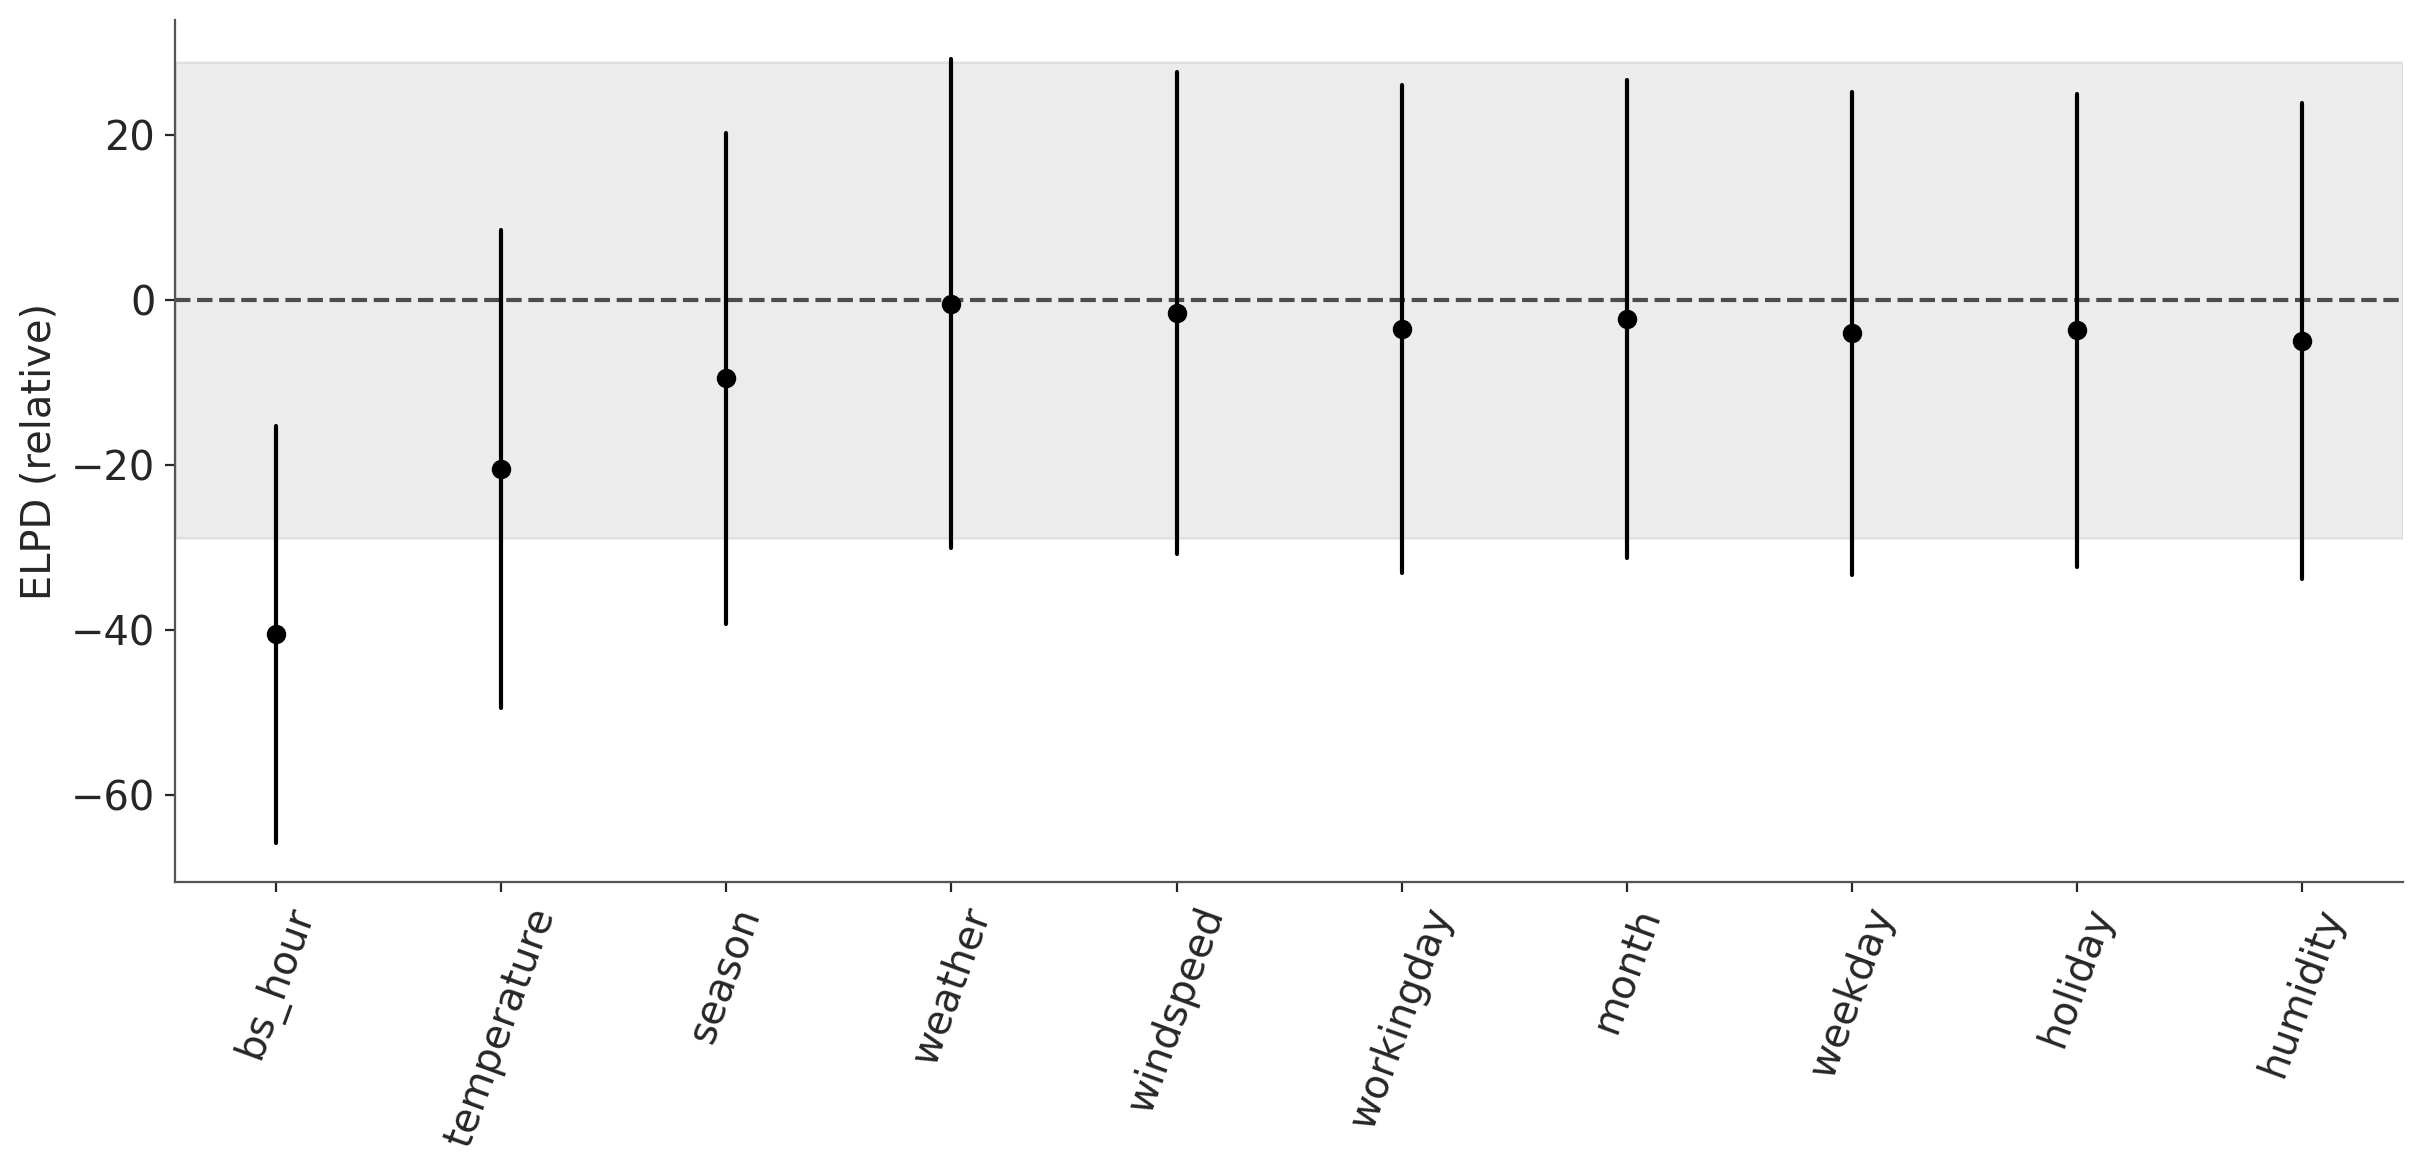

In [13]:
kpt.plot_compare(ppi.compare(min_model_size=1),
                 visuals={"ticklabels":{"rotation": 70}},                 
                 );

We can see that `hour` is the more important variable in the model, followed by `temperature` and then the rest of the variables.

### Early stopping

If we have a lot of variables, we may want to stop the projection early. We can do this by setting the `early_stop` argument (defaults to False). We can pass the strings `mean` or `se`, their meaning is the same as in the `select` method. Or we can pass an integer, which will be the number of submodels to project (or the maximum model size).

In [ ]:
ppi = kpt.ProjectionPredictive(model)
ppi.project(early_stop="mean")
kpt.plot_compare(ppi.compare(min_model_size=1))

/home/osvaldo/proyectos/00_BM/bambinos/kulprit/kulprit/projector.py:306: UserWarning: No InferenceData object provided. Building posterior from model.
  warnings.warn("No InferenceData object provided. Building posterior from model.")
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, bs_hour, season, month, holiday, weekday, workingday, weather, temperature, humidity, windspeed]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


## Speeding up the projection

There are a few options we can use to speed up the projection. It's important to note that all of them will reduce the accuracy of the results. Still, a faster projection could be useful when we have numerous variables, and we want to perform a preliminary analysis. 

To better understand the options we need to understand how Kulprit works. You can read the [overview](https://kulprit.readthedocs.io/en/latest/examples/overview.html) for details, but in short, Kulprit performs a search over the terms in the model to find the best submodels for each size, and then it evaluates the performance of each selected submodel. The evaluation step is done by projecting each selected submodel and then computing the ELPD (using PSIS-LOO-CV method) {cite:t}`Vehtari_2017, Vehtari_2024`, the result of this evaluation step is what you see when calling `compare` and `plot_compare`. 

To speed up the search step Kulprit use a clustering algorithm to group the predictions from the reference model. The number of clusters can be controlled using the `num_clusters` argument. A lower value will speed up the computation, but it will also reduce the accuracy of the search. The default value is 20, but for a quick analysis, a lower like 10 or even 5 could be acceptable.

During the evaluation step, Kulprit uses a higher number of samples from the posterior predictive. This is controlled using the `num_samples` argument, which defaults to 400. A lower value like 100 could still provide reasonable results.

Another option is to completelly skip the search step. By default Kulprit use a forward search (`method="forward"`), but we can also use `method="L1"`. This is faster than the default because no projection is done during the search, instead Kulprit performs a lasso search over the terms. And the projection is done only for the selected submodels. This is useful if we have many variables, and we want to quickly find the best submodels. The downside is that the search step is less accurate as we loose the benefit of the projection during the search.

Additionally, the argument `user_terms` can be used to provide the list of terms/submodels that we want to project. This is faster as no search is done. This can be used if we want to use some other method of search not yet implemented in Kulprit (see for example [PyMC-BART](https://arviz-devs.github.io/EABM/Chapters/Variable_selection.html#combining-pymc-bart-and-kulprit)).

## References
```{bibliography}
:style: unsrt
```